In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 60

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
X_test = pd.read_csv('data/X_test.csv')
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')

# Exploration

In [3]:
print(f"Shape x test {X_test.shape}")
print(f"Shape x train {X_train.shape}")
print(f"Shape y train {y_train.shape}")

Shape x test (3765, 10)
Shape x train (33884, 10)
Shape y train (33884, 2)


In [4]:
X_test.columns

Index(['id', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Private_room', 'Entire_home/apt'],
      dtype='object')

In [5]:
X_train.columns

Index(['id', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Private_room', 'Entire_home/apt'],
      dtype='object')

In [6]:
y_train.columns

Index(['id', 'price'], dtype='object')

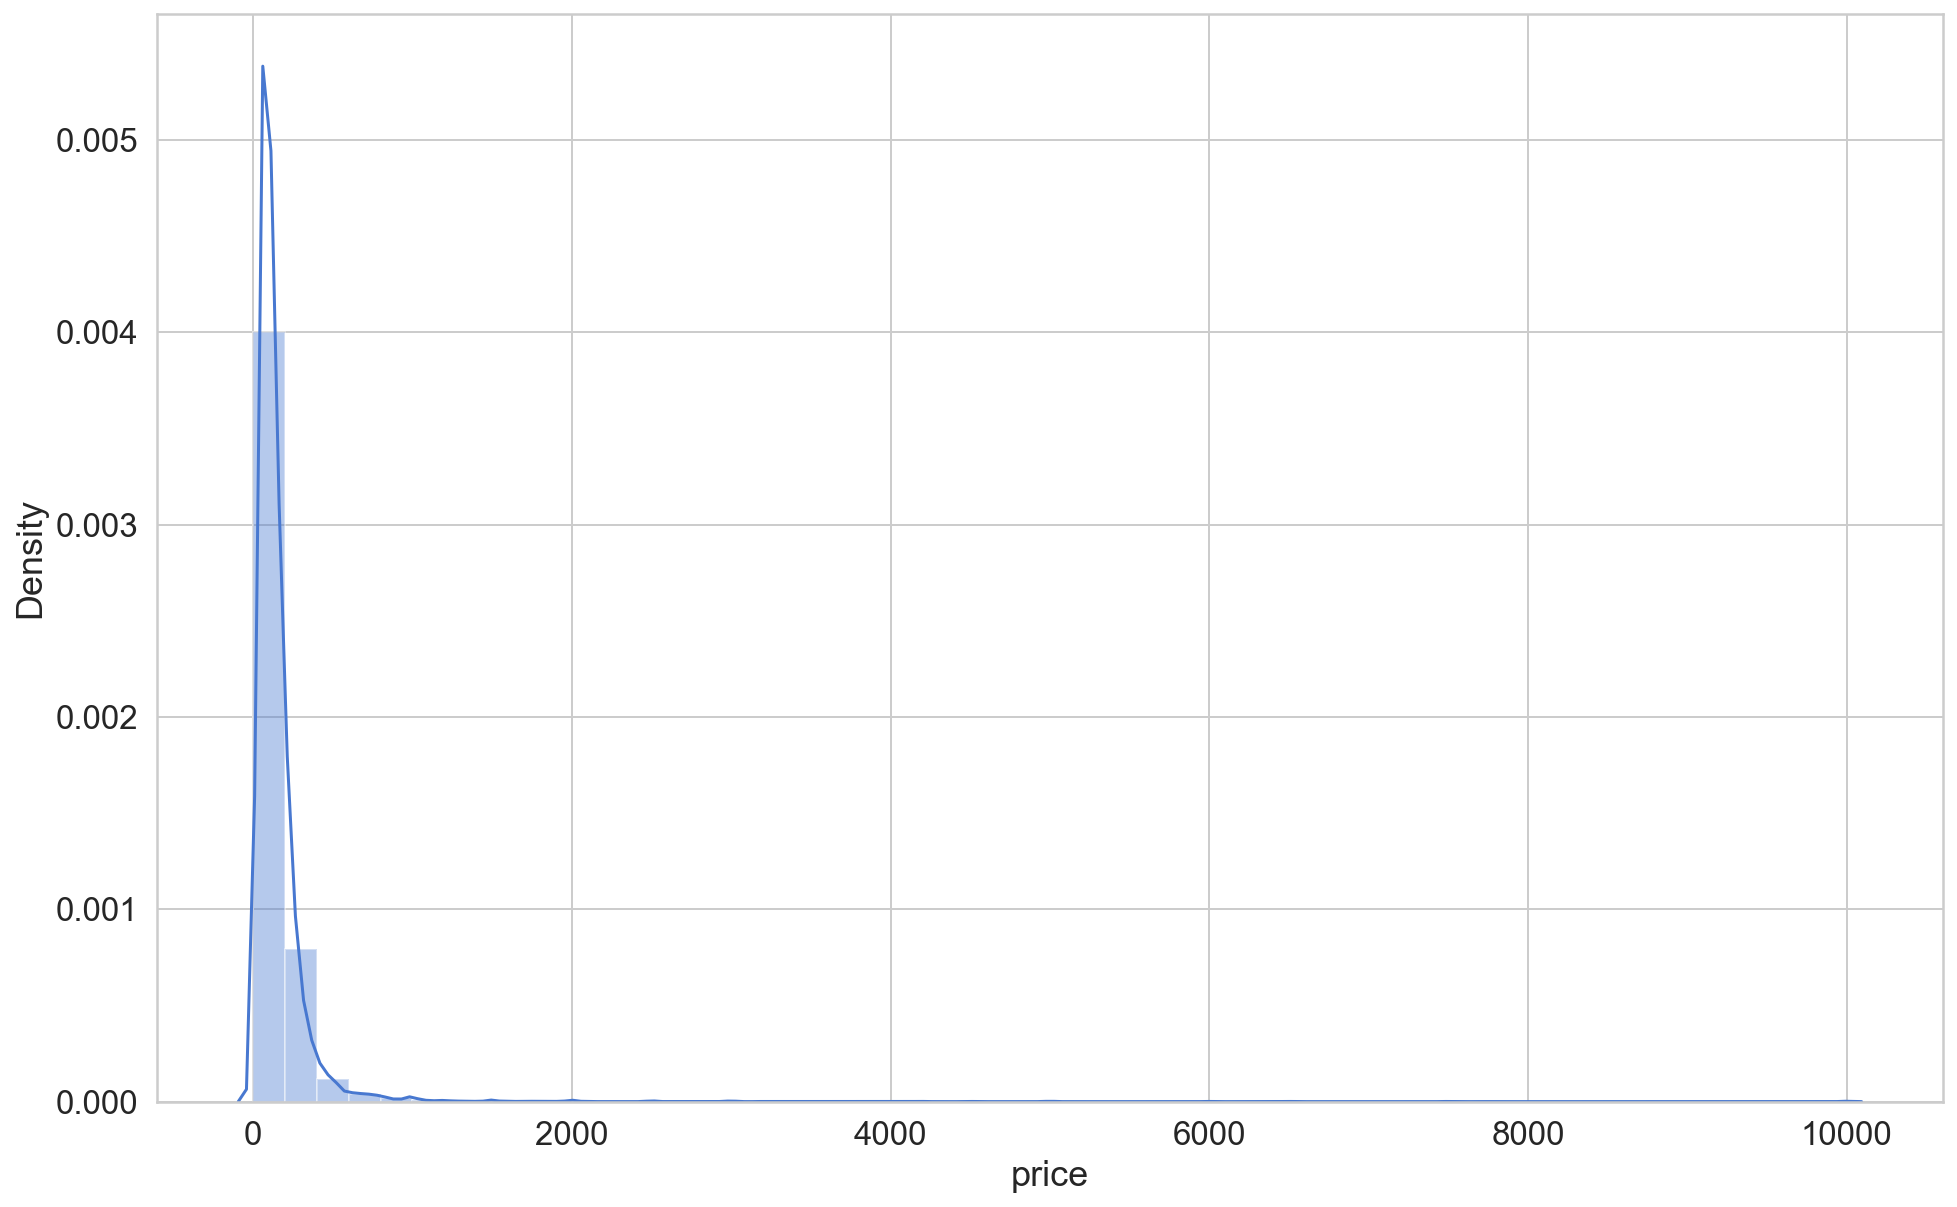

In [7]:
sns.distplot(y_train.price);

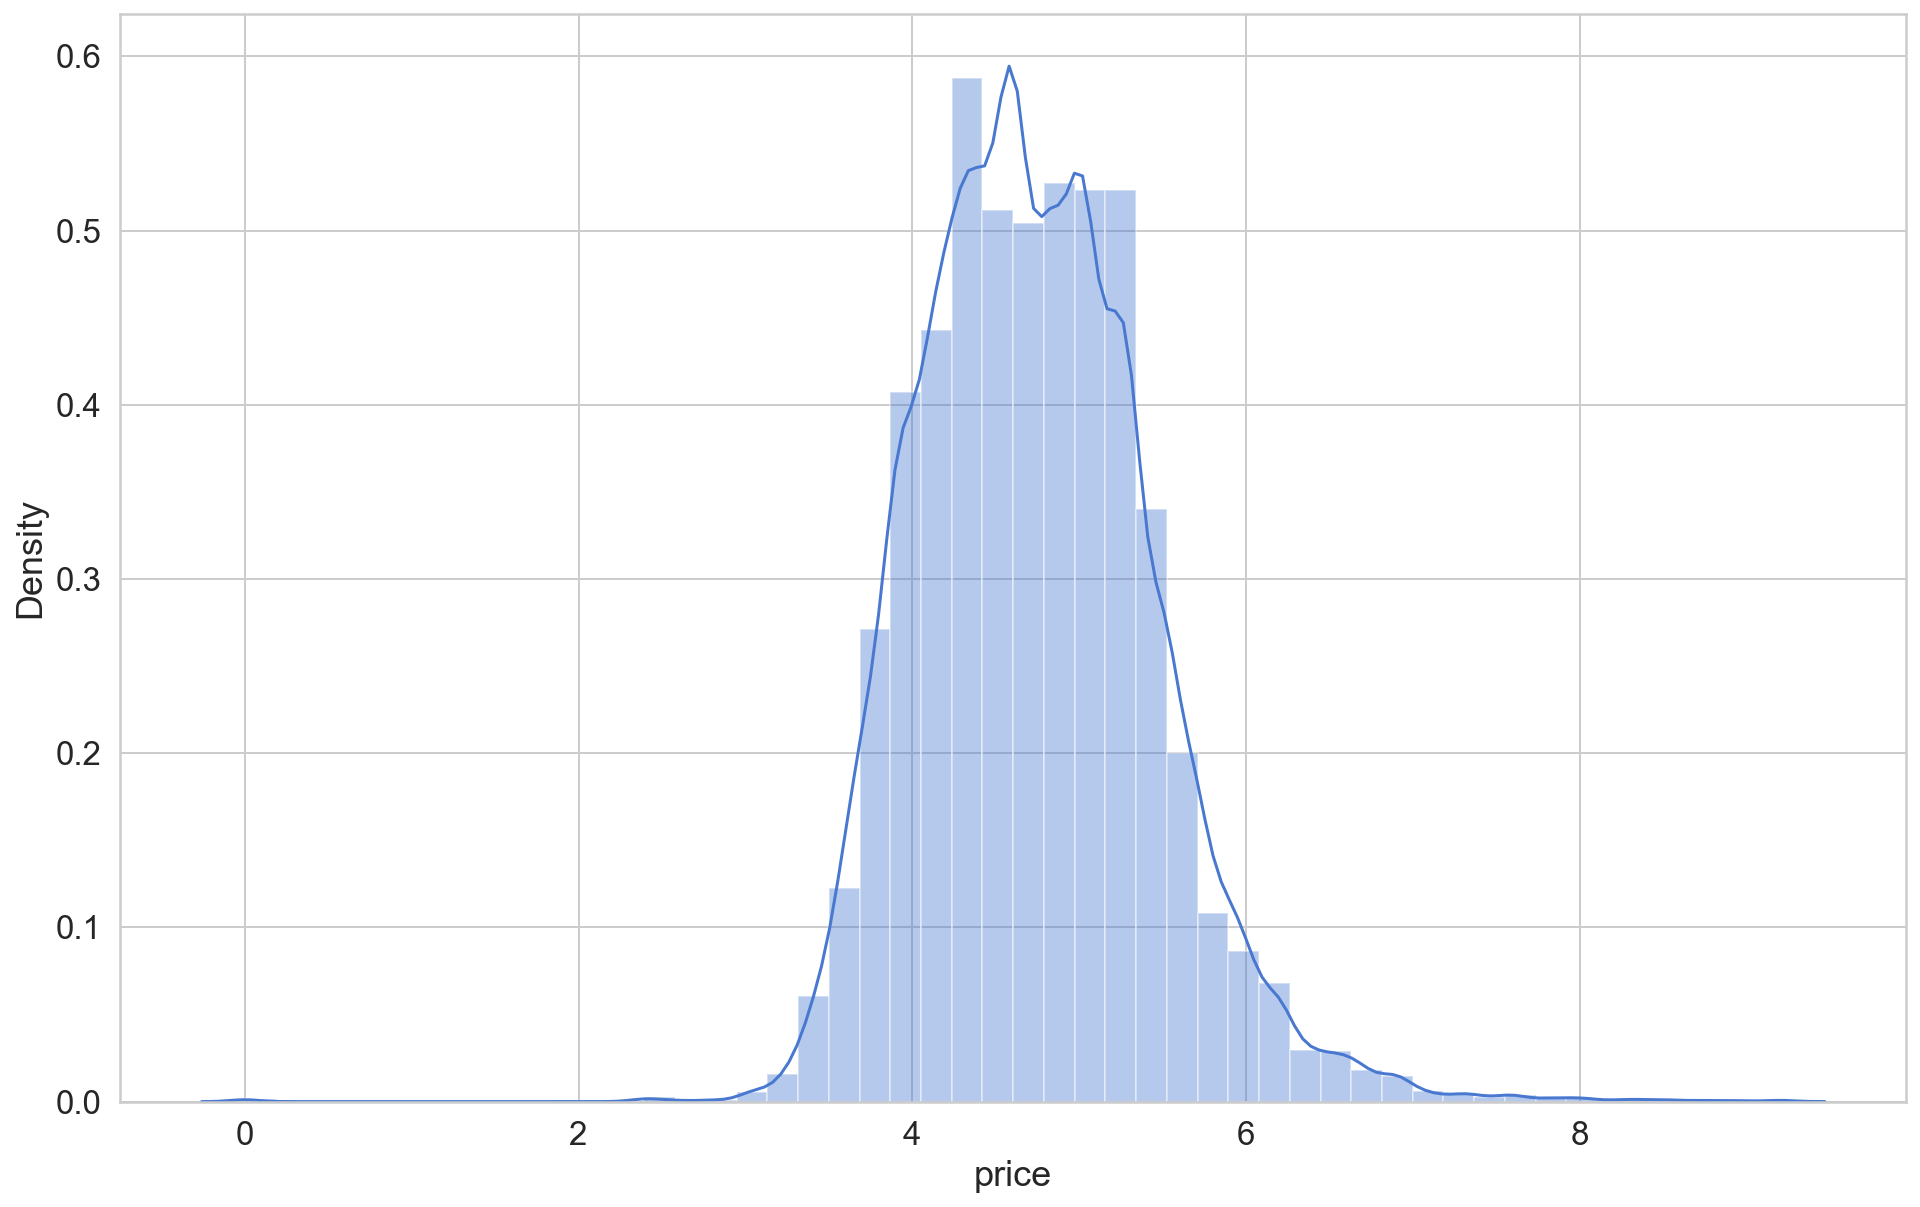

In [8]:
sns.distplot(np.log1p(y_train.price));

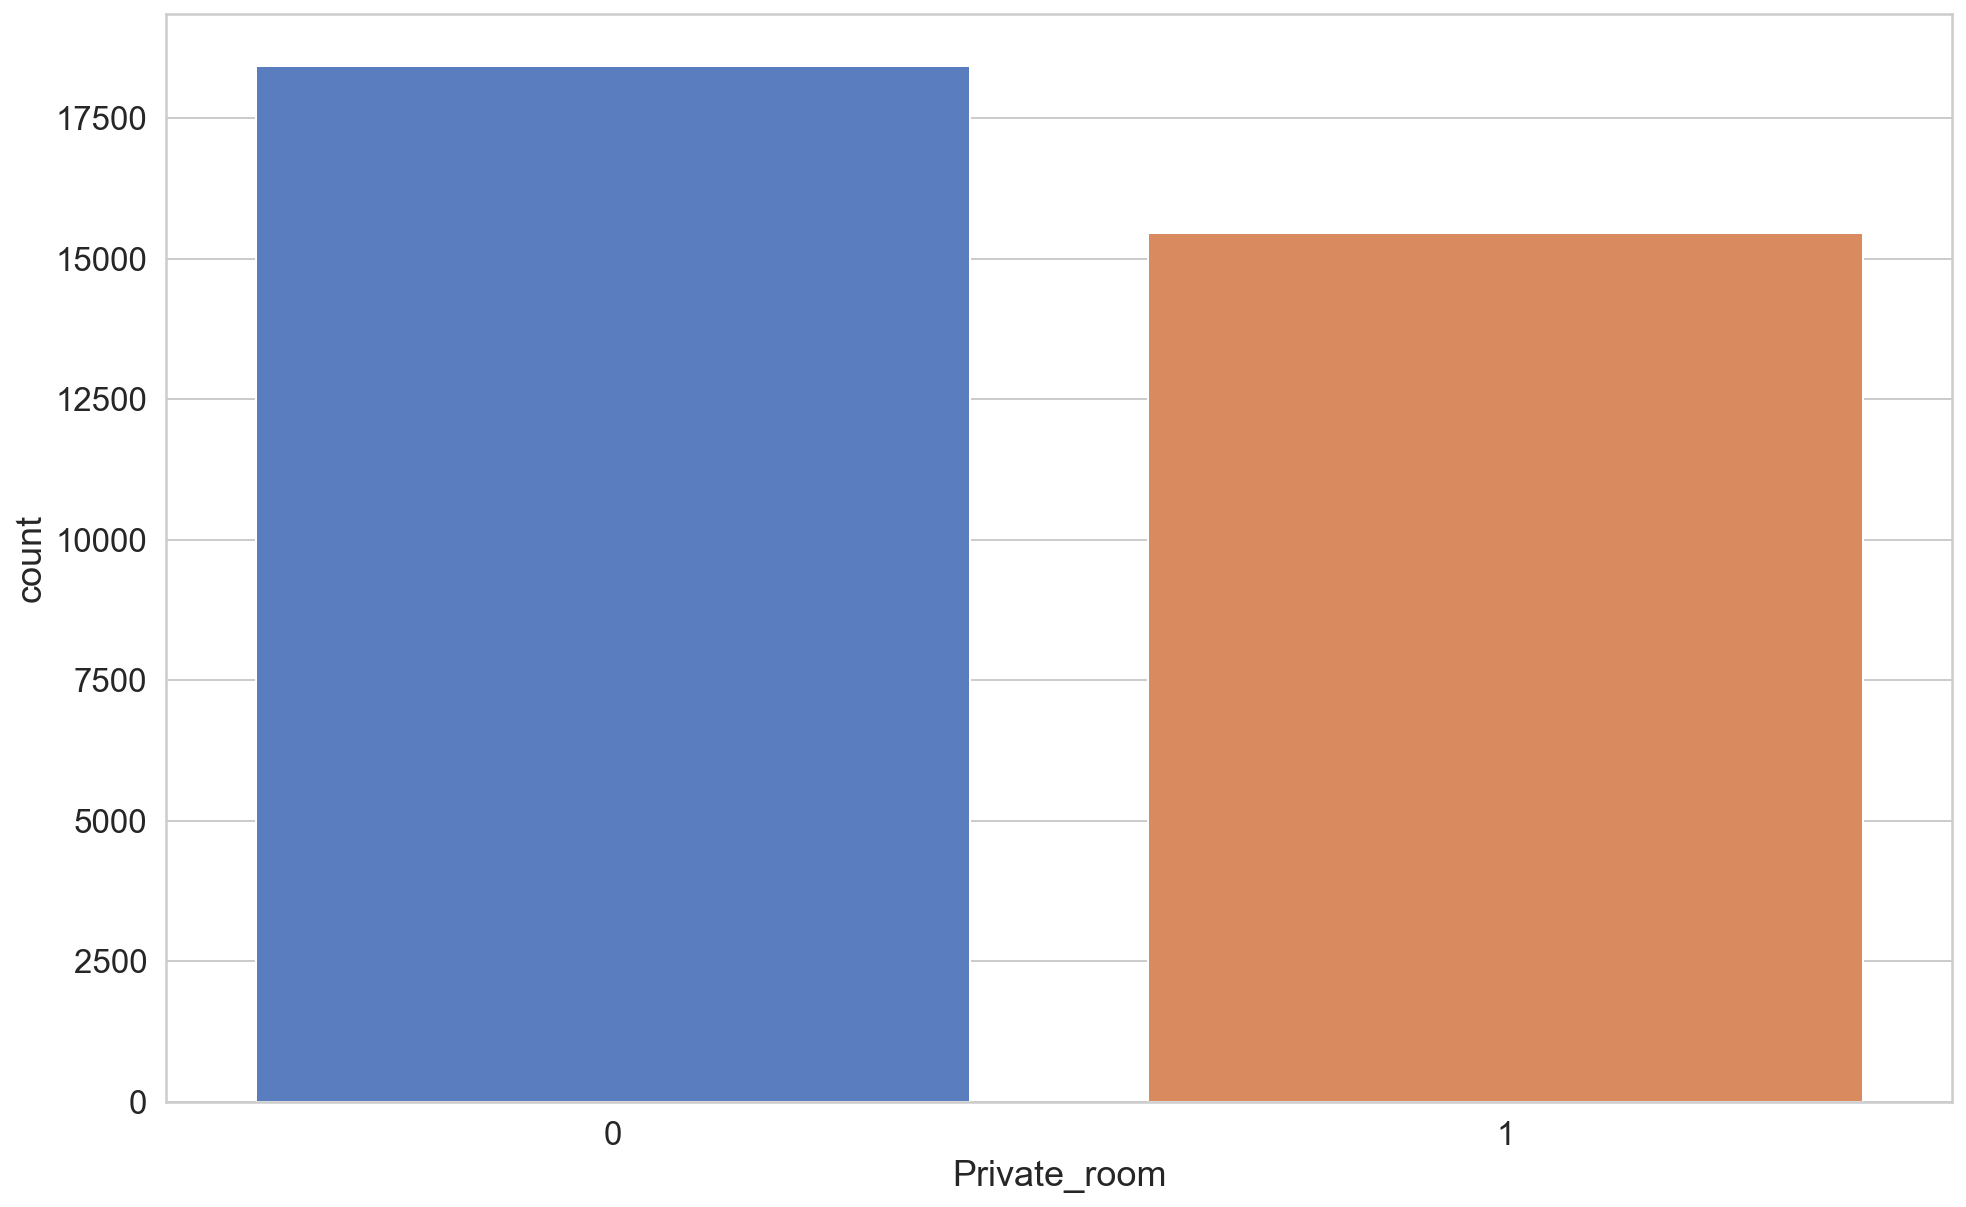

In [9]:
sns.countplot(x='Private_room', data=X_train);

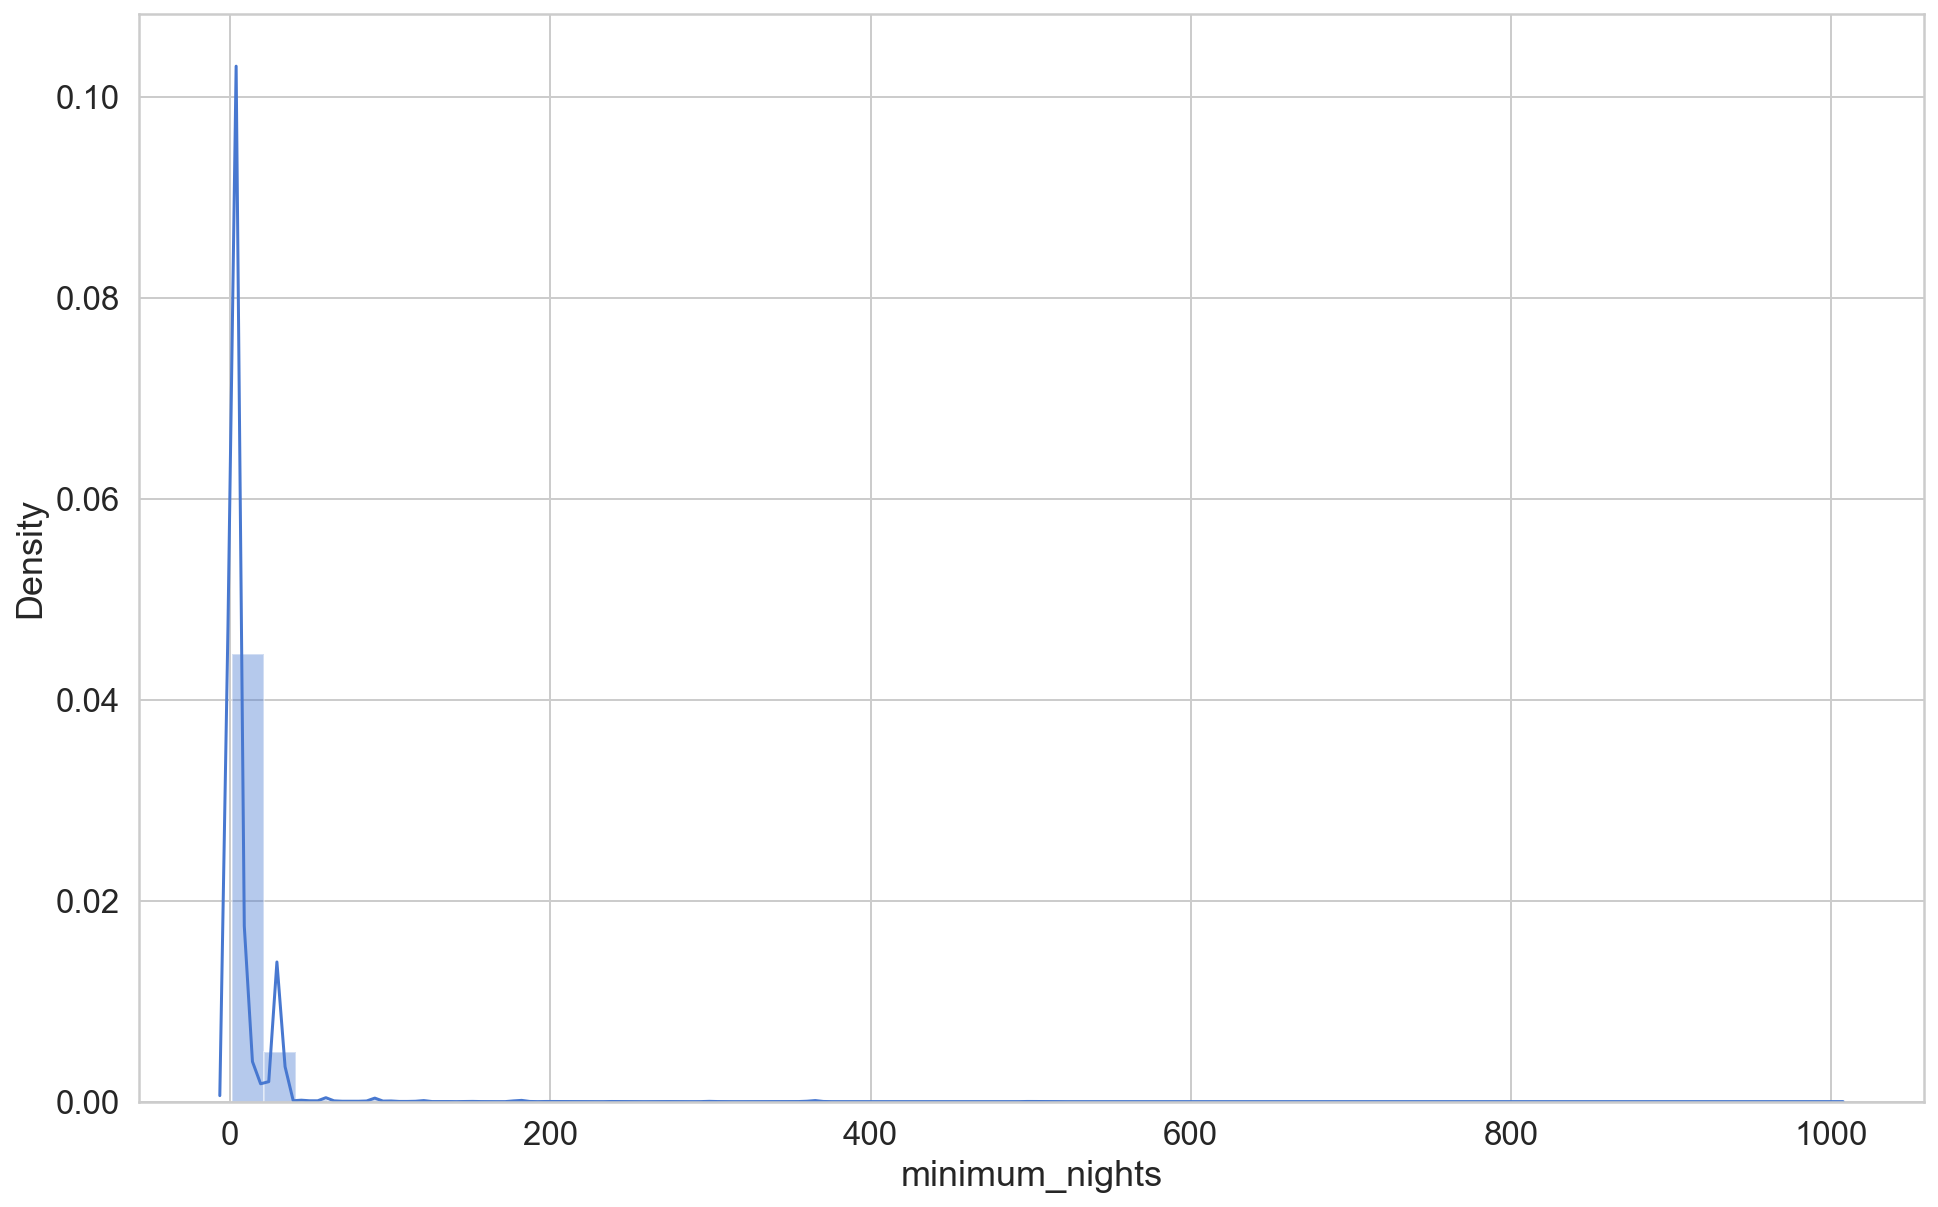

In [10]:
sns.distplot(X_train.minimum_nights);

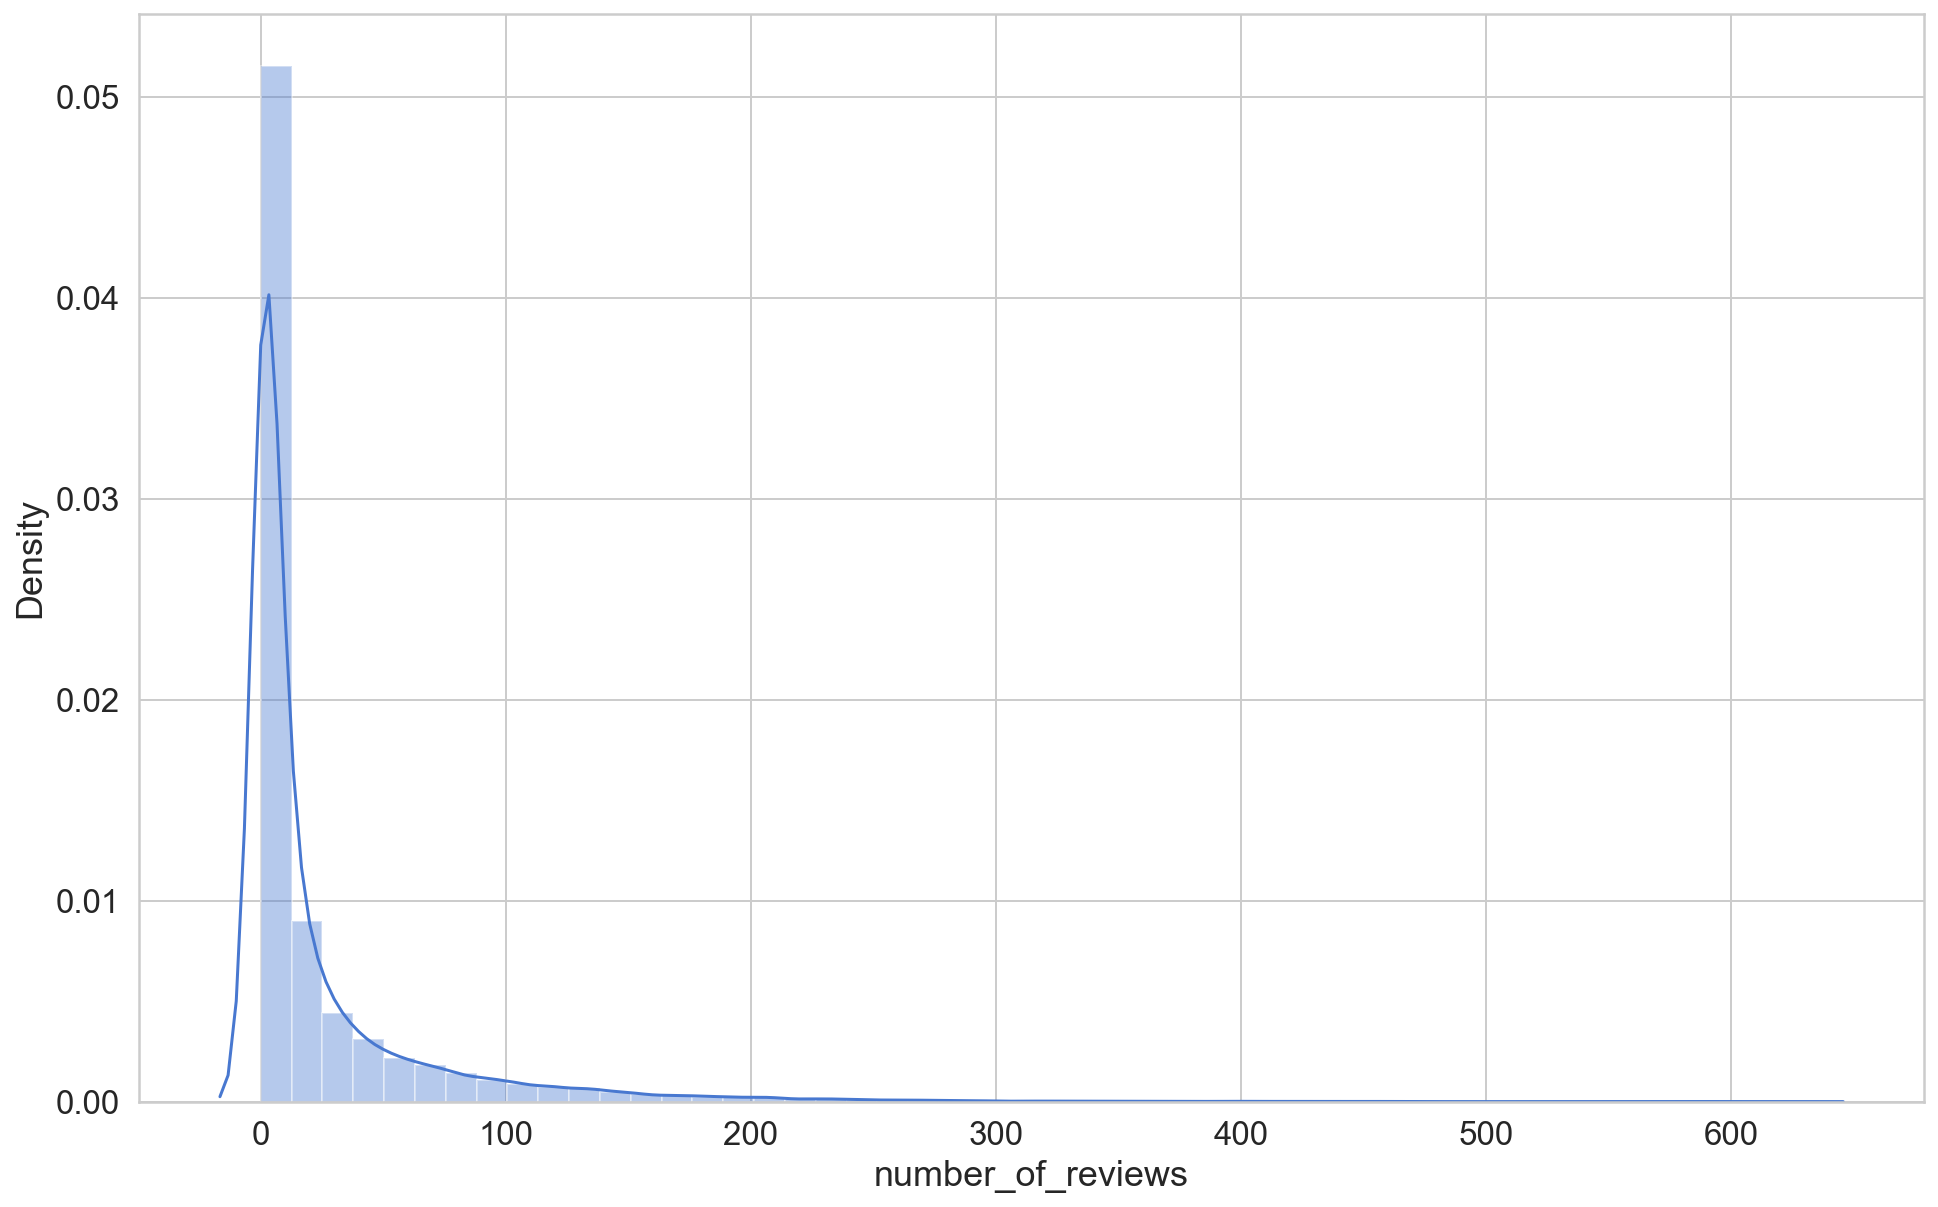

In [11]:
sns.distplot(X_train.number_of_reviews);

In [12]:
corr_matrix = X_train.corr()
corr_matrix_y = y_train.corr()

In [13]:
price_corr = corr_matrix_y['price']
price_corr.iloc[price_corr.abs().argsort()]

id      -0.008333
price    1.000000
Name: price, dtype: float64

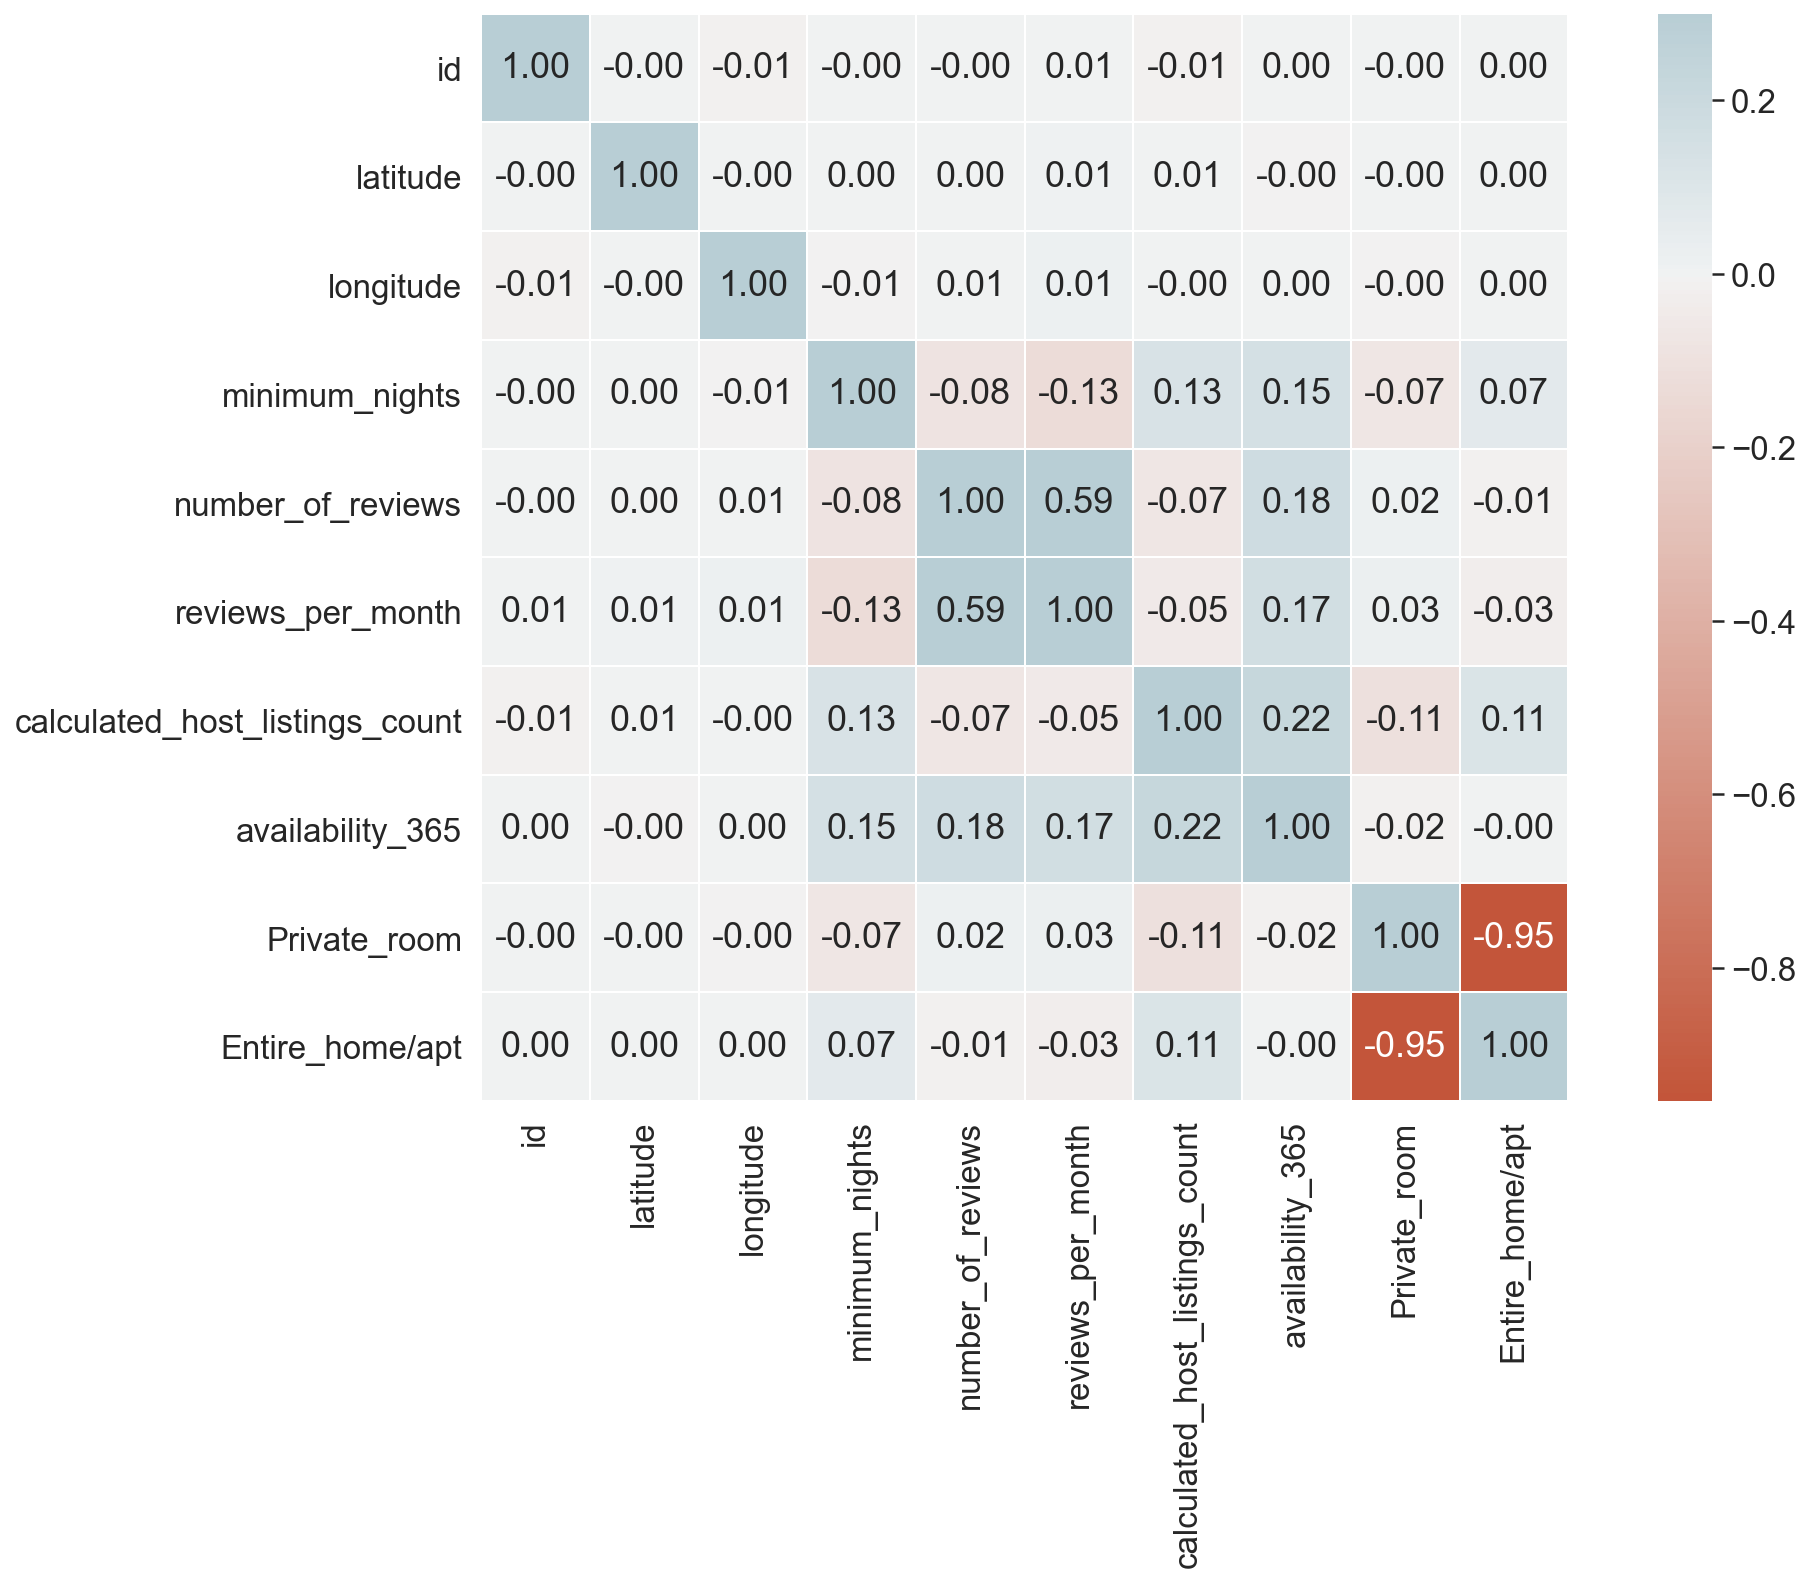

In [14]:
palette = sns.diverging_palette(20, 220, n=256)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5);

# Preprocessing




## Missing data?

In [15]:
missing = X_train.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [16]:
missing_y = y_train.isnull().sum()
missing_y[missing_y > 0].sort_values(ascending=False)

Series([], dtype: int64)

## Remove unused columns!


In [17]:
X_train = X_train.drop('id', axis=1)
X_test = X_test.drop('id', axis=1)
y_train = y_train.drop('id', axis=1)

In [18]:
missing = X_train.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [19]:
X_train.columns

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Private_room', 'Entire_home/apt'],
      dtype='object')

In [20]:
X_train.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
0,40.71239,-73.95271,4,2,0.19,1,0,1,0
1,40696.00000,-73.91303,4,17,0.66,2,307,1,0
2,40.62707,-74.02817,3,1,0.04,1,87,0,0
3,40.77910,-73.98565,1,4,0.08,1,0,0,1
4,40.75777,-73.93509,1,0,0.00,1,358,1,0


## Predict log1p

In [21]:
X = X_train
y = np.log1p(y_train.price.values)

## Feature scaling

In [22]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


transformer = make_column_transformer(
    (MinMaxScaler(), X_train.columns))

In [23]:
transformer.fit(X)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Private_room', 'Entire_home/apt'],
      dtype='object'))])

In [24]:
# scaling
X = transformer.transform(X)

## Split the training and test data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [26]:
X_train.shape

(27107, 9)

### Neural Network Model (3-layers)

In [27]:
def plot_mse(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.plot(hist['epoch'], hist['mse'],
            label='Train MSE')
  plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val MSE')
  plt.legend()
  plt.show()

Epoch 1/100
678/678 [==============================] - 1s 2ms/step - loss: 4.7365 - mse: 4.7365 - val_loss: 0.3555 - val_mse: 0.3555
Epoch 2/100
678/678 [==============================] - 3s 4ms/step - loss: 0.3431 - mse: 0.3431 - val_loss: 0.3226 - val_mse: 0.3226
Epoch 3/100
678/678 [==============================] - 2s 3ms/step - loss: 0.3165 - mse: 0.3165 - val_loss: 0.3055 - val_mse: 0.3055
Epoch 4/100
678/678 [==============================] - 3s 4ms/step - loss: 0.3030 - mse: 0.3030 - val_loss: 0.2958 - val_mse: 0.2958
Epoch 5/100
678/678 [==============================] - 2s 3ms/step - loss: 0.2980 - mse: 0.2980 - val_loss: 0.2933 - val_mse: 0.2933
Epoch 6/100
678/678 [==============================] - 2s 3ms/step - loss: 0.2960 - mse: 0.2960 - val_loss: 0.2914 - val_mse: 0.2914
Epoch 7/100
678/678 [==============================] - 2s 3ms/step - loss: 0.2947 - mse: 0.2947 - val_loss: 0.2896 - val_mse: 0.2896
Epoch 8/100
678/678 [==============================] - 2s 3ms/step - 

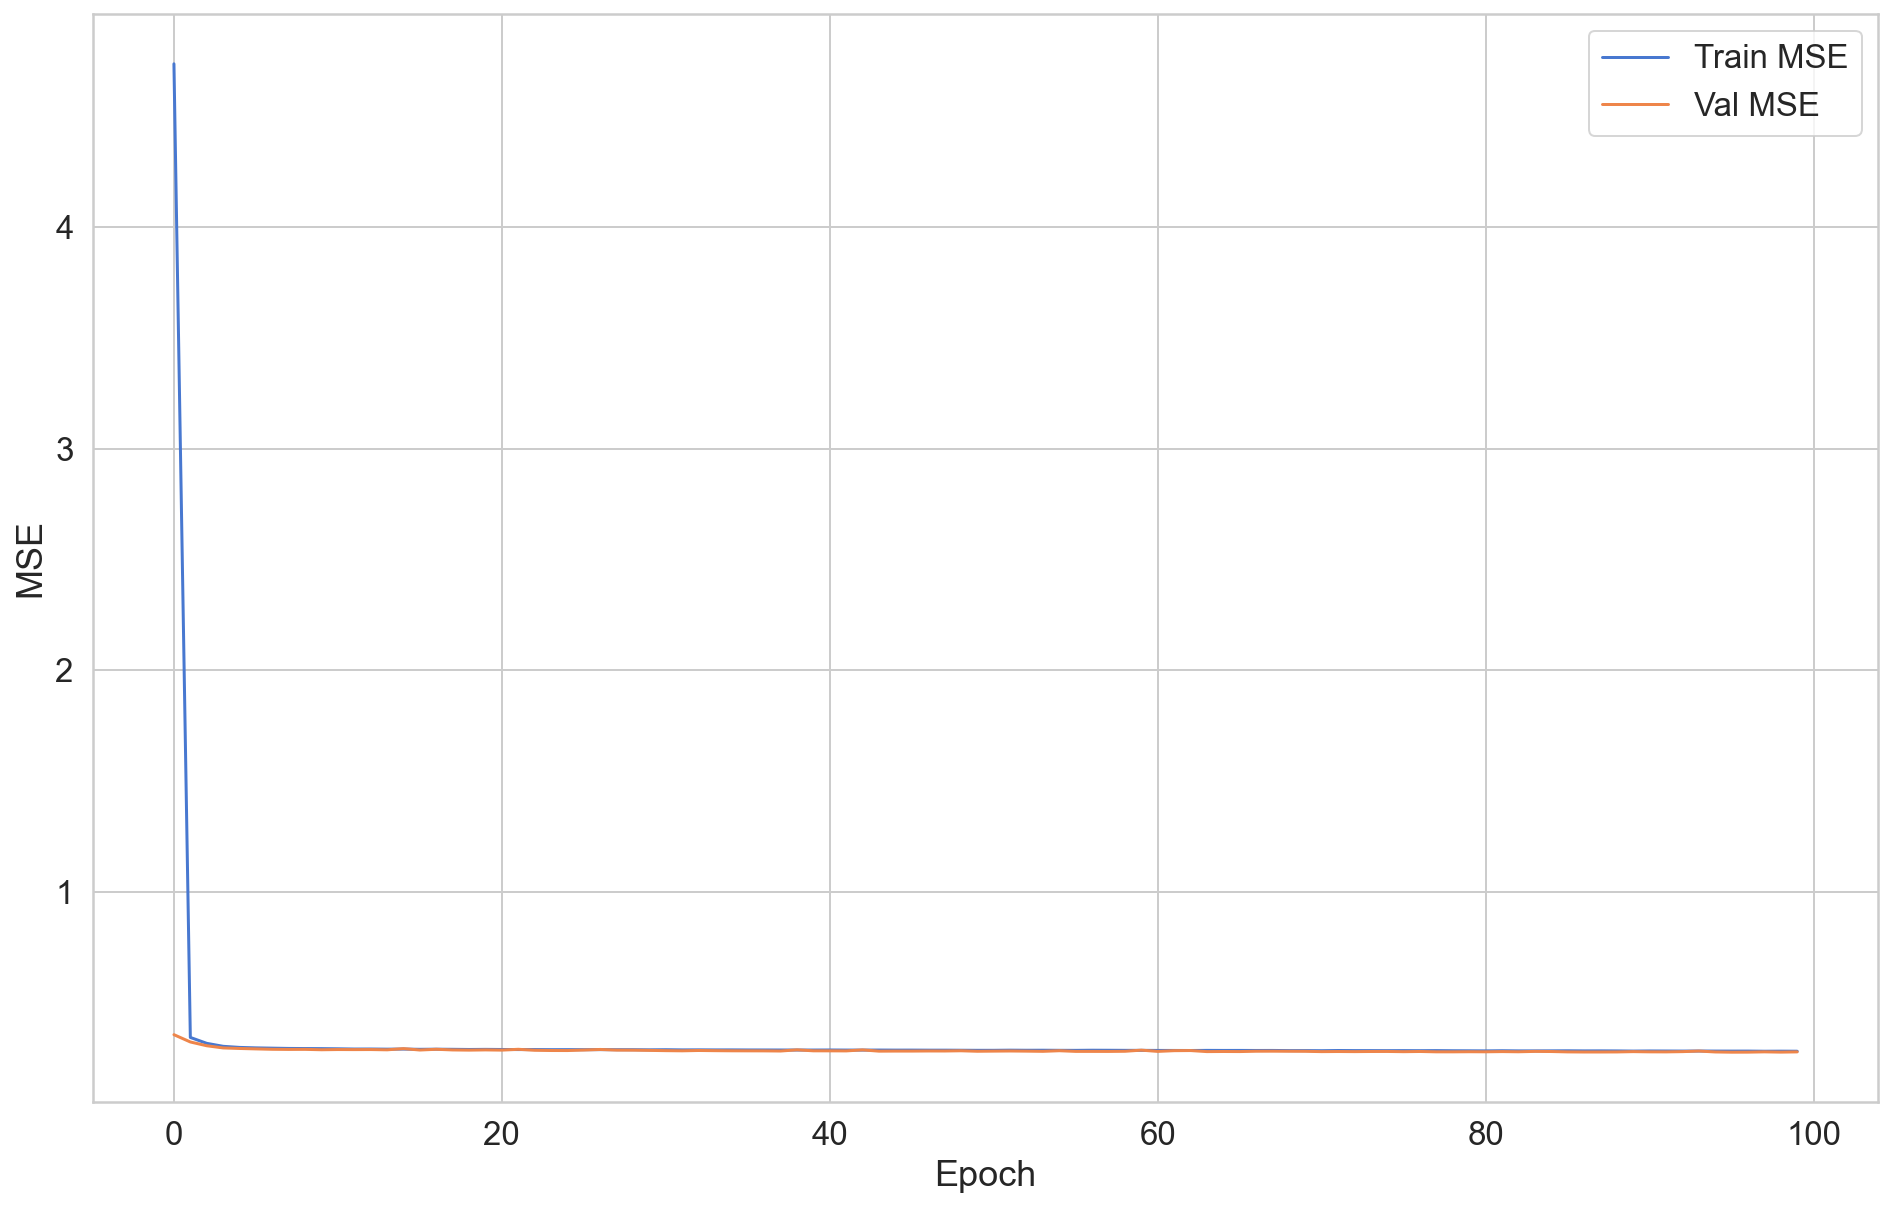

In [28]:
model1 = keras.Sequential()
model1.add(keras.layers.Dense(units=32, activation="relu", input_shape=[X_train.shape[1]]))
model1.add(keras.layers.Dense(units=64, activation="relu"))
model1.add(keras.layers.Dense(units=128, activation='relu'))

model1.add(keras.layers.Dense(1, activation="linear"))

model1.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = 'mse', 
    metrics = ['mse'])

BATCH_SIZE = 32

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_mse',
  mode="min",
  patience=10
)

history = model1.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_mse(history)

### Four-layer neural network and more epochs model

50
339/339 [==============================] - 2s 6ms/step - loss: 0.4299 - mse: 0.4299 - val_loss: 0.3759 - val_mse: 0.3759
Epoch 3/150
339/339 [==============================] - 3s 8ms/step - loss: 0.3298 - mse: 0.3298 - val_loss: 0.3110 - val_mse: 0.3110
Epoch 4/150
339/339 [==============================] - 3s 8ms/step - loss: 0.3101 - mse: 0.3101 - val_loss: 0.3053 - val_mse: 0.3053
Epoch 5/150
339/339 [==============================] - 2s 7ms/step - loss: 0.3070 - mse: 0.3070 - val_loss: 0.3026 - val_mse: 0.3026
Epoch 6/150
339/339 [==============================] - 2s 7ms/step - loss: 0.3058 - mse: 0.3058 - val_loss: 0.3049 - val_mse: 0.3049
Epoch 7/150
339/339 [==============================] - 2s 7ms/step - loss: 0.3040 - mse: 0.3040 - val_loss: 0.2987 - val_mse: 0.2987
Epoch 8/150
339/339 [==============================] - 2s 7ms/step - loss: 0.3018 - mse: 0.3018 - val_loss: 0.2972 - val_mse: 0.2972
Epoch 9/150
339/339 [==============================] - 3s 8ms/step - loss: 0.3

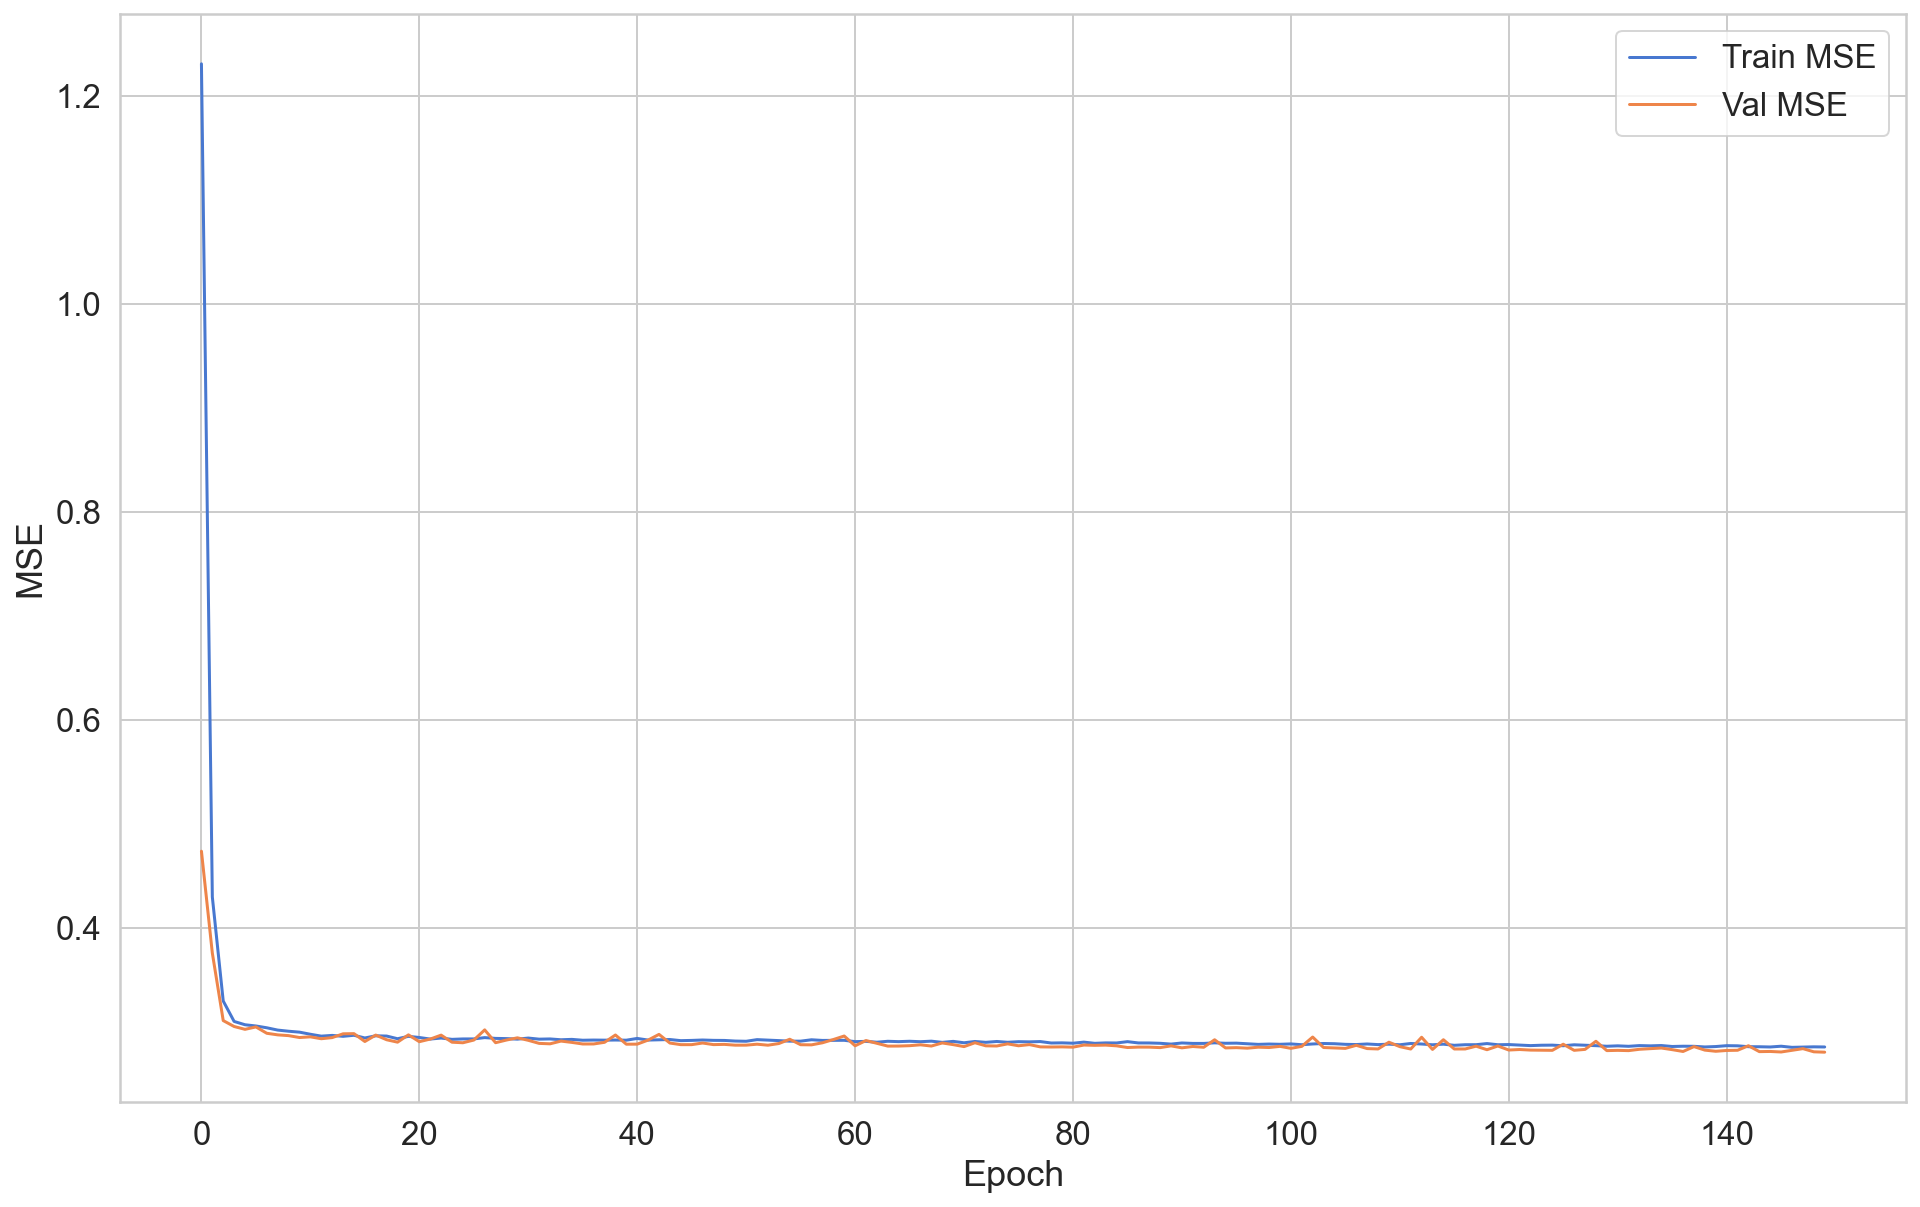

In [29]:
model2 = keras.Sequential()
model2.add(keras.layers.Dense(units=64, activation="relu", input_shape=[X_train.shape[1]]))
model2.add(keras.layers.Dense(units=128, activation="sigmoid"))
model2.add(keras.layers.Dense(units=256, activation="sigmoid"))
model2.add(keras.layers.Dense(units=512, activation="relu"))
model2.add(keras.layers.Dense(1, activation='linear'))

model2.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = 'mse', 
    metrics = ['mse'])

BATCH_SIZE = 64

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_mse',
  mode="min",
  patience=10
)

history = model2.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=150,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_mse(history)

### Neural Network with SDG optimizer

50
339/339 [==============================] - 2s 7ms/step - loss: 0.3291 - mse: 0.3291 - val_loss: 0.3709 - val_mse: 0.3709
Epoch 3/150
339/339 [==============================] - 2s 7ms/step - loss: 0.3131 - mse: 0.3131 - val_loss: 0.2965 - val_mse: 0.2965
Epoch 4/150
339/339 [==============================] - 2s 7ms/step - loss: 0.3112 - mse: 0.3112 - val_loss: 0.3099 - val_mse: 0.3099
Epoch 5/150
339/339 [==============================] - 2s 7ms/step - loss: 0.3018 - mse: 0.3018 - val_loss: 0.2891 - val_mse: 0.2891
Epoch 6/150
339/339 [==============================] - 2s 7ms/step - loss: 0.3080 - mse: 0.3080 - val_loss: 0.2889 - val_mse: 0.2889
Epoch 7/150
339/339 [==============================] - 2s 7ms/step - loss: 0.3045 - mse: 0.3045 - val_loss: 0.2896 - val_mse: 0.2896
Epoch 8/150
339/339 [==============================] - 2s 7ms/step - loss: 0.3023 - mse: 0.3023 - val_loss: 0.2905 - val_mse: 0.2905
Epoch 9/150
339/339 [==============================] - 2s 6ms/step - loss: 0.2

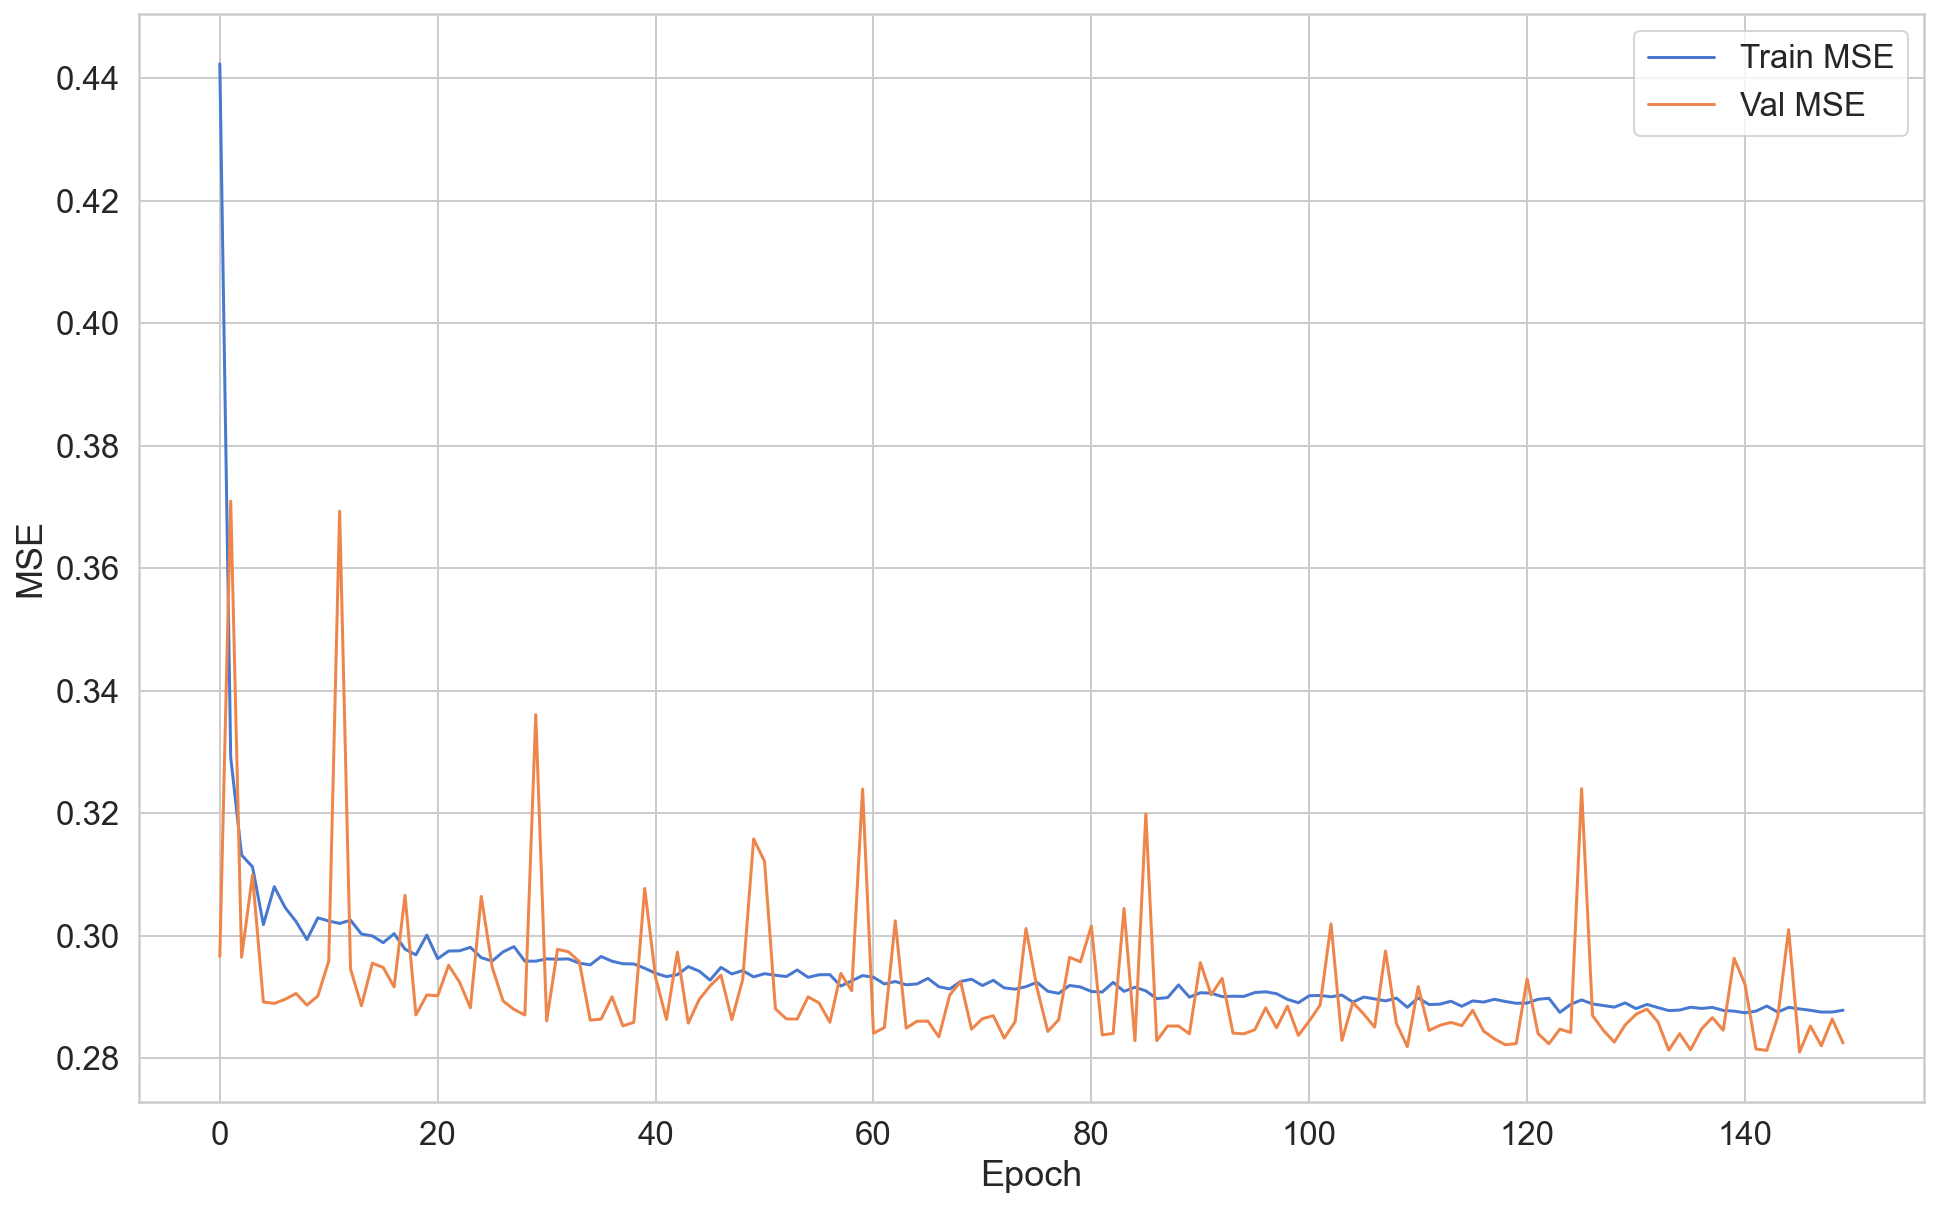

In [30]:
model3 = keras.Sequential()
model3.add(keras.layers.Dense(units=64, activation="relu", input_shape=[X_train.shape[1]]))
model3.add(keras.layers.Dense(units=128, activation="selu"))
model3.add(keras.layers.Dense(units=256, activation="selu"))
model3.add(keras.layers.Dense(units=512, activation="relu"))
model3.add(keras.layers.Dense(1, activation='linear'))

model3.compile(
    optimizer='SGD',
    loss = 'mse', 
    metrics = ['mse'])

BATCH_SIZE = 64

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_mse',
  mode="min",
  patience=10
)

history = model3.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=150,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_mse(history)

### Neural Network with dropout regularization at 50%

50
339/339 [==============================] - 2s 5ms/step - loss: 0.6588 - mse: 0.6588 - val_loss: 1.5405 - val_mse: 1.5405
Epoch 3/150
339/339 [==============================] - 2s 6ms/step - loss: 0.5837 - mse: 0.5837 - val_loss: 0.7010 - val_mse: 0.7010
Epoch 4/150
339/339 [==============================] - 2s 6ms/step - loss: 0.5447 - mse: 0.5447 - val_loss: 0.4953 - val_mse: 0.4953
Epoch 5/150
339/339 [==============================] - 2s 7ms/step - loss: 0.5092 - mse: 0.5092 - val_loss: 0.4250 - val_mse: 0.4250
Epoch 6/150
339/339 [==============================] - 2s 6ms/step - loss: 0.5002 - mse: 0.5002 - val_loss: 0.4216 - val_mse: 0.4216
Epoch 7/150
339/339 [==============================] - 2s 6ms/step - loss: 0.4918 - mse: 0.4918 - val_loss: 0.3627 - val_mse: 0.3627
Epoch 8/150
339/339 [==============================] - 2s 6ms/step - loss: 0.4842 - mse: 0.4842 - val_loss: 0.3674 - val_mse: 0.3674
Epoch 9/150
339/339 [==============================] - 2s 6ms/step - loss: 0.4

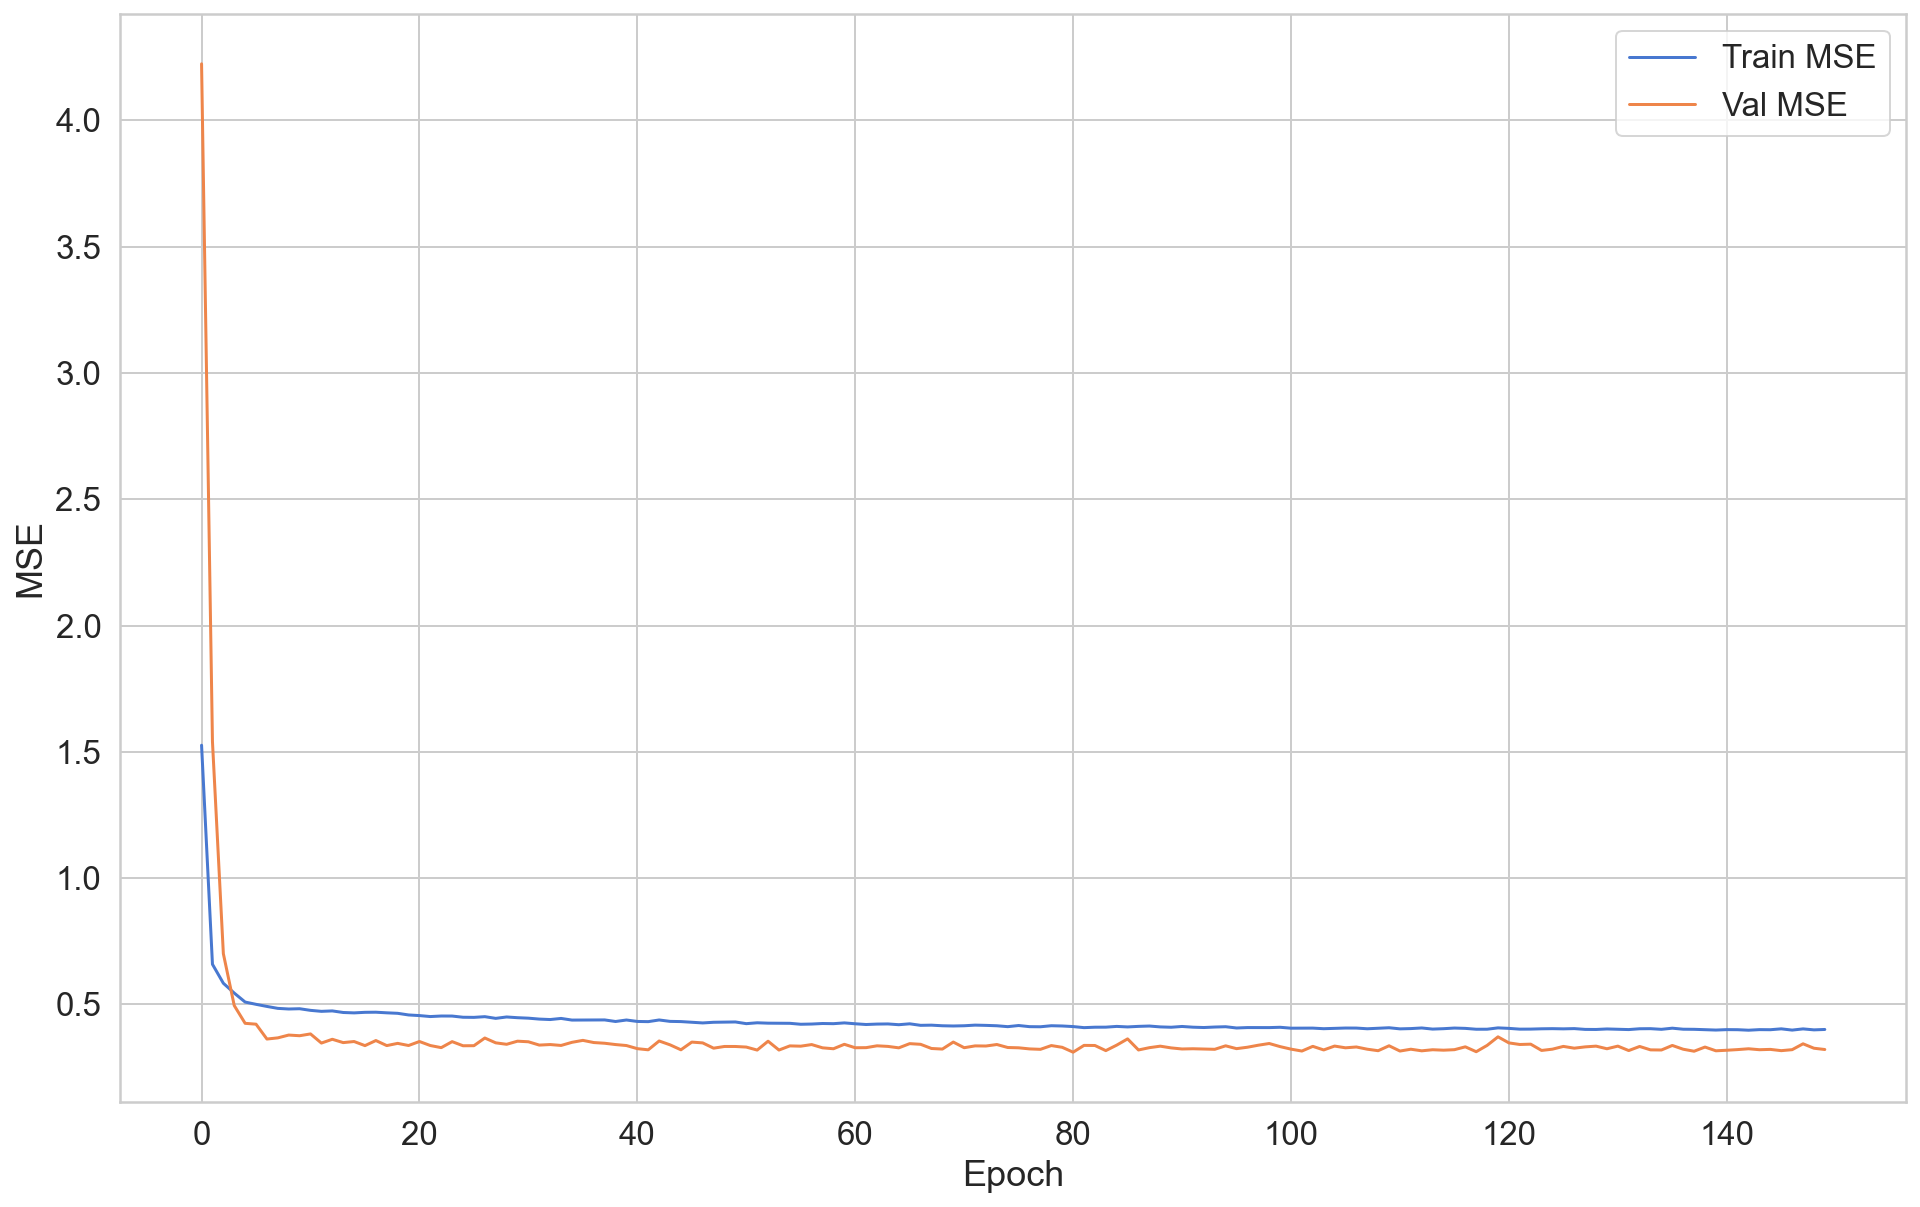

In [31]:
model4 = keras.Sequential()
model4.add(keras.layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
model4.add(keras.layers.Dense(units=128, activation="relu"))
model4.add(keras.layers.Dropout(0.5))
model4.add(keras.layers.Dense(units=256, activation="relu"))
model4.add(keras.layers.Dropout(0.5))
model4.add(keras.layers.Dense(units=512, activation="relu"))
model4.add(keras.layers.Dropout(0.5))
model4.add(keras.layers.Dense(1, activation='linear'))

model4.compile(
    optimizer='adam',
    loss = 'mse', 
    metrics = ['mse'])

BATCH_SIZE = 64

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_mse',
  mode="min",
  patience=15
)

history = model4.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=150,
  validation_split=0.2,
  batch_size=BATCH_SIZE
)

plot_mse(history)

In [32]:
import time
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.0 minutes

Training MSE: 0.1296
Validation MSE: 0.2065

Training r2: 0.7326
Validation r2: 0.5828


### Model Evaluation

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

In [34]:
f = open("Mirko_Lantieri_858278_score1.txt", "a+")

In [35]:
y_pred = model1.predict(X_test)

In [36]:
print(f'MSE {mean_squared_error(y_test, y_pred)}')
print(f'MAE {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 {r2_score(y_test, y_pred)}')

MSE 0.2821209050290158
MAE 0.3934433364372566
RMSE 0.5311505483655419
R2 0.4299887470821828


In [37]:
f.write(f"{np.array2string(np.expm1(y_pred),  separator=',')}\n")

96

In [38]:
y_pred = model2.predict(X_test)

In [39]:
print(f'MSE {mean_squared_error(y_test, y_pred)}')
print(f'MAE {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 {r2_score(y_test, y_pred)}')

MSE 0.2852159162253565
MAE 0.3893421514819327
RMSE 0.534056098387947
R2 0.42373543093873933


In [40]:
f.write(f"{np.array2string(np.expm1(y_pred),  separator=',')}\n")

96

In [41]:
y_pred = model3.predict(X_test)

In [42]:
print(f'MSE {mean_squared_error(y_test, y_pred)}')
print(f'MAE {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 {r2_score(y_test, y_pred)}')

MSE 0.2863689202705159
MAE 0.3954222547228138
RMSE 0.5351344880219513
R2 0.4214058436281747


In [43]:
f.write(f"{np.array2string(np.expm1(y_pred),  separator=',')}\n")

96

In [44]:
y_pred = model4.predict(X_test)

In [45]:
print(f'MSE {mean_squared_error(y_test, y_pred)}')
print(f'MAE {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 {r2_score(y_test, y_pred)}')

MSE 0.323951555103329
MAE 0.424994437956569
RMSE 0.5691674227354628
R2 0.3454719997083088


In [46]:
f.write(f"{np.array2string(np.expm1(y_pred),  separator=',')}\n")
f.close()

In [47]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4)) 
    
       
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 0.281
Validation MSE: 0.2821

Training r2: 0.4203
Validation r2: 0.43


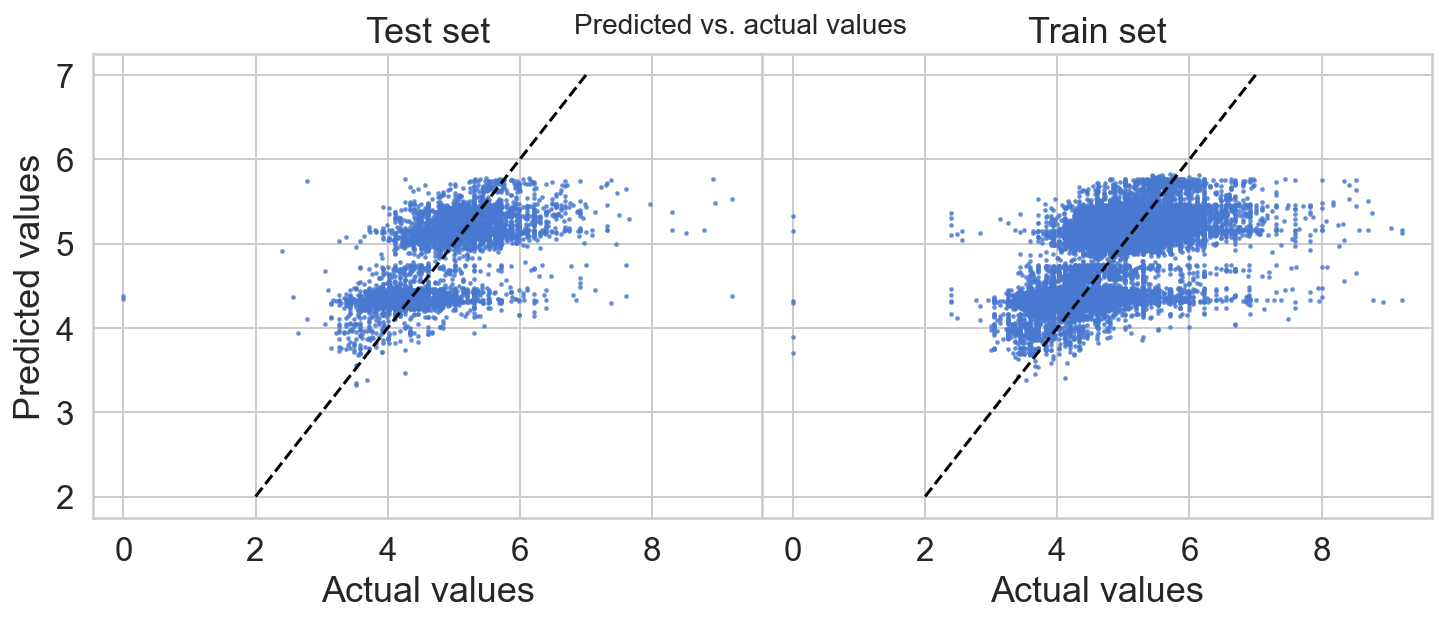

In [48]:
nn_model_evaluation(model1)

Training MSE: 0.2829
Validation MSE: 0.2852

Training r2: 0.4164
Validation r2: 0.4237


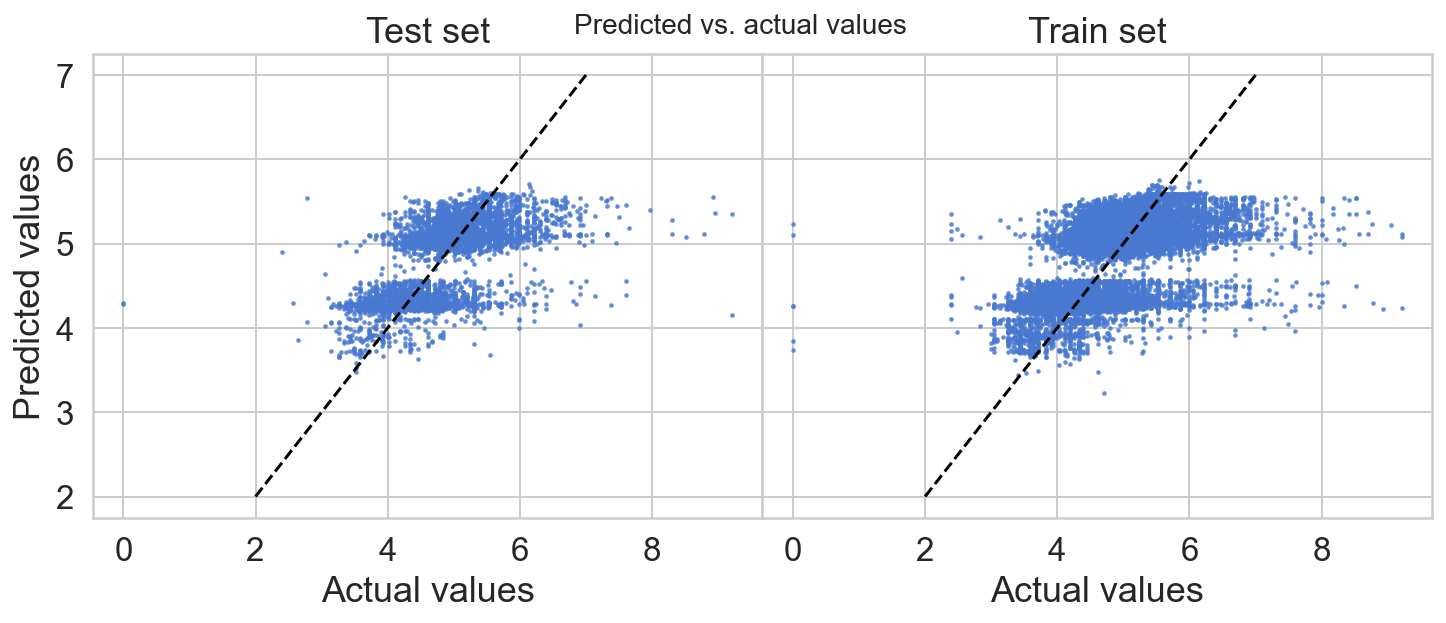

In [49]:
nn_model_evaluation(model2)

Training MSE: 0.2848
Validation MSE: 0.2864

Training r2: 0.4126
Validation r2: 0.4214


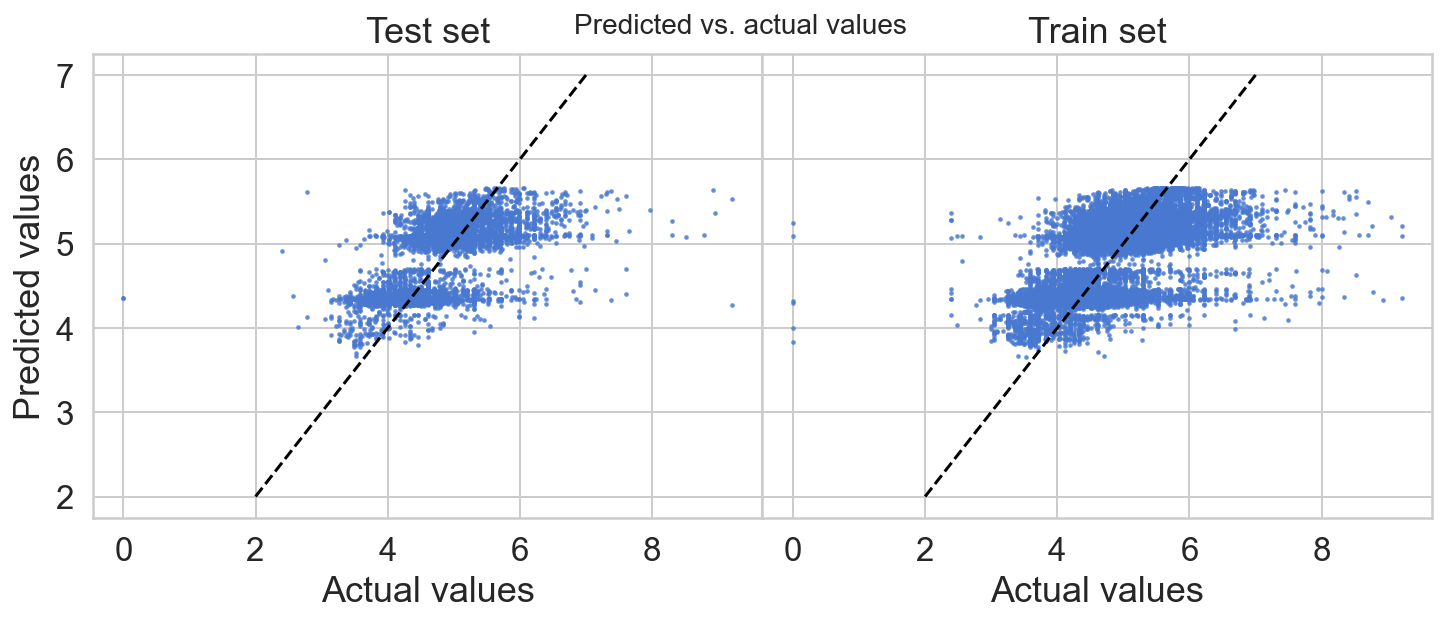

In [50]:
nn_model_evaluation(model3)

Training MSE: 0.3234
Validation MSE: 0.324

Training r2: 0.3329
Validation r2: 0.3455


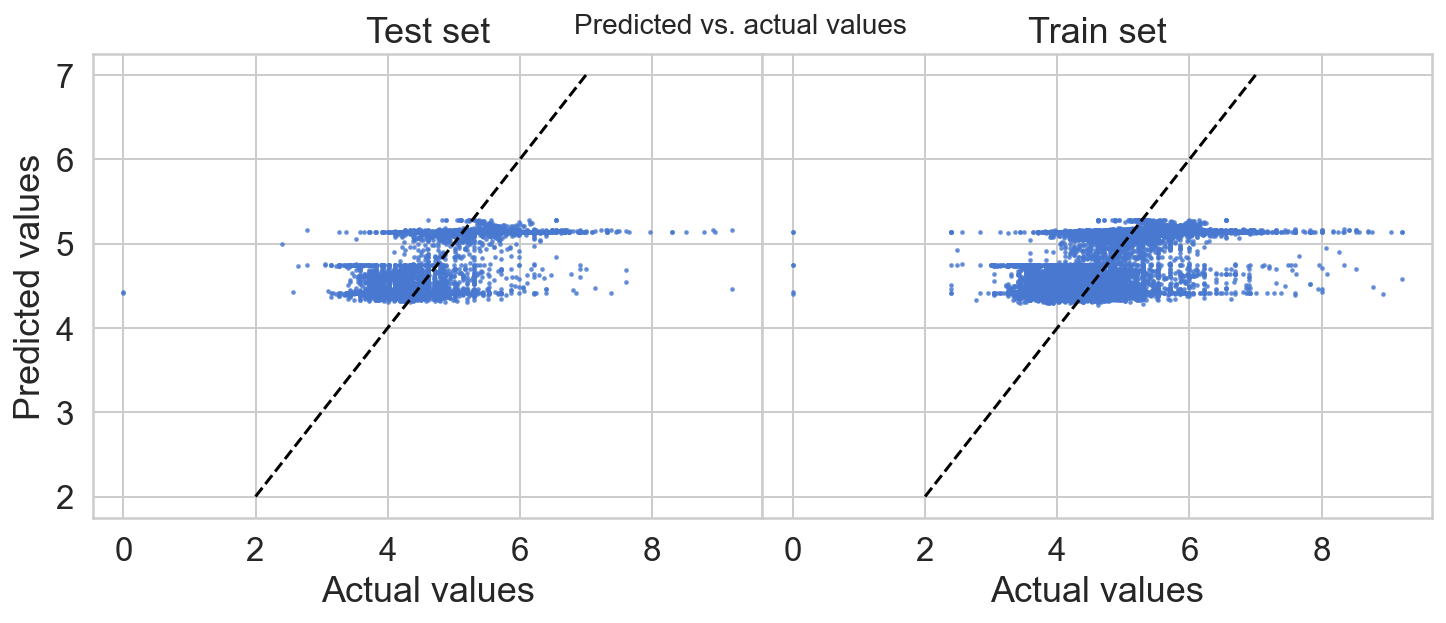

In [51]:
nn_model_evaluation(model4)

Training MSE: 0.1296
Validation MSE: 0.2065

Training r2: 0.7326
Validation r2: 0.5828


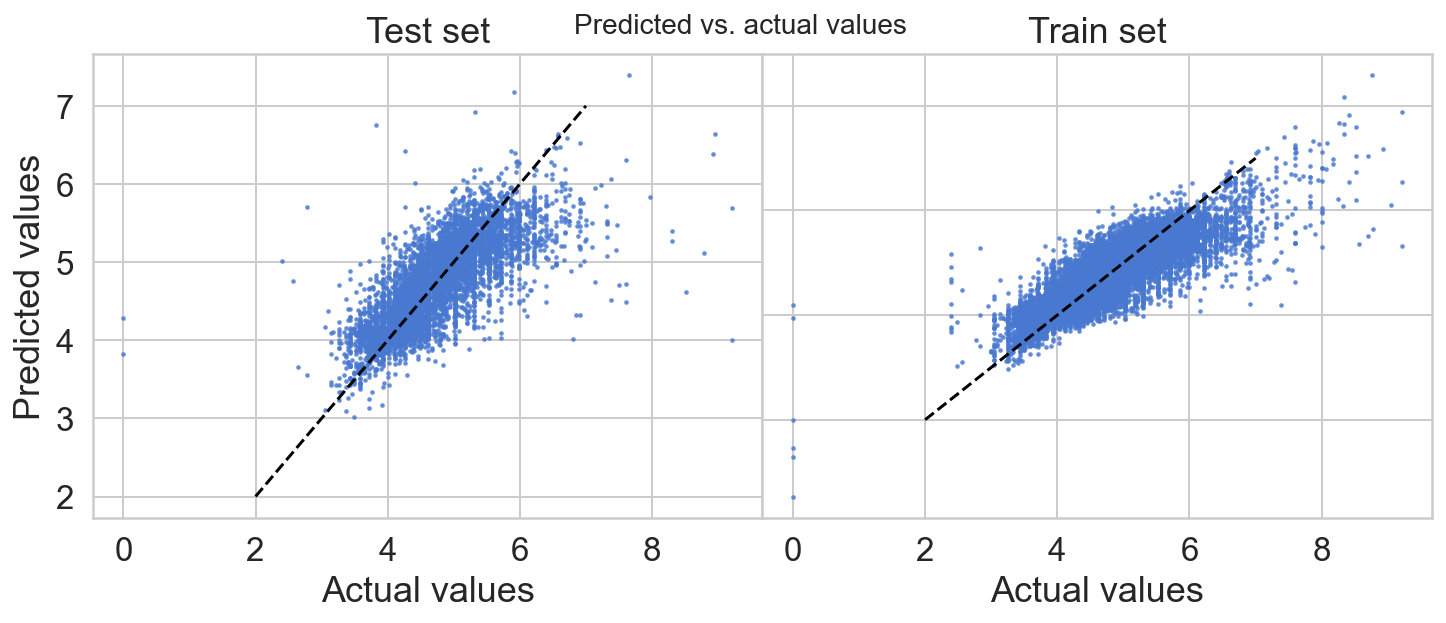

In [52]:
nn_model_evaluation(xgb_reg)